<a href="https://colab.research.google.com/github/TheAmirHK/EnergyOptimization_projects/blob/main/EnergyDispatchOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyomo
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [3]:
# Define model
model = ConcreteModel()

In [4]:
# In[dataset]
# Sets
T = range(24*7)  # Time periods (e.g., 1 week)
G = range(3)   # Thermal generators

# Parameters
np.random.seed(42)
D = {t: np.random.uniform(80, 120) for t in T}  # Demand (MW)
W = {t: np.random.uniform(30, 70) for t in T}   # Wind energy available (MW)
S = {t: np.random.uniform(20, 50) for t in T}   # Solar energy available (MW)

C_g = [50, 55, 60]  # Generation cost ($/MWh)
P_g_min = [10, 15, 20]  # Min power generation (MW)
P_g_max = [50, 60, 70]  # Max power generation (MW)
Startup_cost = [200, 250, 300]  # Startup cost ($)
Shutdown_cost = [100, 120, 150]  # Shutdown cost ($)
C_b = 5  # Battery storage cost ($/MWh)
C_dr = 30  # Demand response compensation ($/MWh)
Battery_capacity = 50  # Max storage (MWh)
eta_c, eta_d = 0.9, 0.9  # Charging/discharging efficiency
alpha = 0.2  # Max demand reduction

In [5]:
# In[Decision variables]
model.P_g = Var(G, T, within=NonNegativeReals)
model.u_g = Var(G, T, within=Binary)
model.v_g = Var(G, T, within=Binary)
model.w_g = Var(G, T, within=Binary)
model.P_w = Var(T, within=NonNegativeReals, bounds=lambda m, t: (0, W[t]))
model.P_s = Var(T, within=NonNegativeReals, bounds=lambda m, t: (0, S[t]))
model.P_b = Var(T, within=NonNegativeReals, bounds=(0, Battery_capacity))
model.S_b = Var(T, within=NonNegativeReals, bounds=(0, Battery_capacity))
model.P_dr = Var(T, within=NonNegativeReals, bounds=lambda m, t: (0, alpha * D[t]))

In [6]:
# In[objective and constraints]
def cost_rule(m):
    return sum(
        sum(C_g[g] * m.P_g[g, t] + Startup_cost[g] * m.v_g[g, t] + Shutdown_cost[g] * m.w_g[g, t] for g in G)
        + C_b * m.S_b[t] + C_dr * m.P_dr[t] for t in T)
model.cost = Objective(rule=cost_rule, sense=minimize)

# constraints
model.balance = ConstraintList()
for t in T:
    model.balance.add(sum(model.P_g[g, t] for g in G) + model.P_w[t] + model.P_s[t] + model.P_b[t] - model.S_b[t] + model.P_dr[t] == D[t])

for g in G:
    for t in T:
        model.balance.add(P_g_min[g] * model.u_g[g, t] <= model.P_g[g, t])
        model.balance.add(model.P_g[g, t] <= P_g_max[g] * model.u_g[g, t])
        if t > 0:
            model.balance.add(model.v_g[g, t] - model.w_g[g, t] == model.u_g[g, t] - model.u_g[g, t-1])

for t in T:
    if t > 0:
        model.balance.add(model.S_b[t] == model.S_b[t-1] + eta_c * model.P_b[t] - model.S_b[t] / eta_d)

In [7]:
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

for t in T:
    print(f"Hour {t}: Demand {D[t]:.1f} MW, Thermal Gen {sum(model.P_g[g, t].value for g in G):.1f} MW, Wind {model.P_w[t].value:.1f} MW, Solar {model.P_s[t].value:.1f} MW, Battery Discharge {model.P_b[t].value:.1f} MW, Demand Response {model.P_dr[t].value:.1f} MW")


Ipopt 3.12.13: 
==> Warning: Treating 1512 binary and 0 integer variables as continous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3849
Number of nonzeros in inequality constraint Jacobian.:     2016
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2856
                     variables with only lower bounds:      504
                variables with lower and upper bounds:    

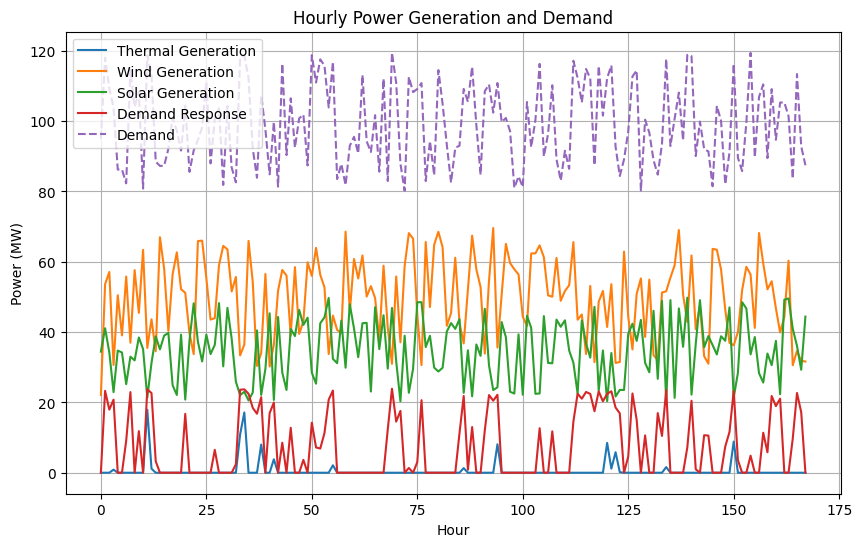

In [11]:
thermal_gen_per_hour = [sum(model.P_g[g, t].value for g in G) for t in T]
wind_gen_per_hour = [model.P_w[t].value for t in T]
solar_gen_per_hour = [model.P_s[t].value for t in T]
demand_response_per_hour = [model.P_dr[t].value for t in T]
demand_per_hour = [D[t] for t in T]
sum_except_demand = 0

plt.figure(figsize=(10, 6))
plt.plot(T, thermal_gen_per_hour, label="Thermal Generation")
plt.plot(T, wind_gen_per_hour, label="Wind Generation")
plt.plot(T, solar_gen_per_hour, label="Solar Generation")
plt.plot(T, demand_response_per_hour, label="Demand Response")
plt.plot(T, demand_per_hour, label="Demand", linestyle="--")
plt.xlabel("Hour")
plt.ylabel("Power (MW)")
plt.title("Hourly Power Generation and Demand")
plt.legend()
plt.grid(True)
plt.show()
